<a href="https://colab.research.google.com/github/rfps09/Colab-Backup/blob/main/PytorchConvNeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
print(dev)

cuda:0


In [ ]:
import torch
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose(
    [
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047]),
    ]
)

augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0,90)),
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047]),
    ]
)

data_path = 'drive/MyDrive/TensorFlow/DataSets/DogsAndCats/'
train_data_path = data_path + 'train/'
test_data_path = data_path + 'test/'

dir_train = torchvision.datasets.ImageFolder(train_data_path,transform=transform)
dir_aug = torchvision.datasets.ImageFolder(train_data_path,transform=augmentation)
dir_train = torch.utils.data.ConcatDataset((dir_train,dir_aug))


train_data = torch.utils.data.DataLoader(dir_train,batch_size=128,shuffle=True,num_workers=0)

dir_test = torchvision.datasets.ImageFolder(test_data_path,transform=transform)
test_data = torch.utils.data.DataLoader(dir_test,batch_size=32,shuffle=True,num_workers=0)
len(train_data.dataset)

1114

In [ ]:
imgs = torch.stack([i for img,_ in test_data for i in img], dim=3)
media = imgs.view(3,-1).mean(dim=1)
desvio = imgs.view(3,-1).std(dim=1)
print(media,desvio)

tensor([ 0.0601,  0.0291, -0.0140]) tensor([1.0133, 1.0140, 1.0218])


In [ ]:
import torch
import torchvision
from torch.nn import functional as F
from torchvision import transforms
from torch import nn

class ConvNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,64,kernel_size=(3,3),padding=(1,1))
    self.conv2 = nn.Conv2d(64,64,kernel_size=(3,3),padding=(1,1))
    self.pool = nn.MaxPool2d(kernel_size=(3,3),stride=2)
    self.layer1 = nn.Linear(64*5*5,256)
    self.layer2 = nn.Linear(256,128)
    self.layer3 = nn.Linear(128,2)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,start_dim=1) #not flatten the batch size
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)
    return x

In [ ]:
def train_one_epoch(NeuralNet,Loss,Optimizer,data_treino):
    NeuralNet.train(True)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = 0

    for i,data in enumerate(data_treino):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        Optimizer.zero_grad()
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()
        loss.backward()
        Optimizer.step()
        
        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
        total_samples += len(x)

    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [ ]:
def validation_one_epoch(NeuralNet,Loss,val_data):
    NeuralNet.train(False)
    current_loss = 0.0
    current_accuracy = 0.0
    total_samples = len(val_data.dataset)
    
    for i,data in enumerate(val_data):
        x,y = data
        x = x.to(device)
        y = y.to(device)
        output = NeuralNet(x)
        loss = Loss(output,y)
        current_loss += loss.item()

        output = output.argmax(dim=1)
        batch_accuracy = torch.eq(output,y)
        batch_accuracy = batch_accuracy.sum()
        current_accuracy += batch_accuracy
    return current_loss/(i+1), (current_accuracy/total_samples).to('cpu')

In [ ]:
from torch import nn
import torchvision.models as models

cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in cnn.layer4.parameters():
    param.requires_grad = True
for param in cnn.layer3.parameters():
    param.requires_grad = True
for param in cnn.avgpool.parameters():
    param.requires_grad = True

in_ftrs = cnn.fc.in_features
cnn.fc = nn.Sequential(
                nn.Linear(in_features=in_ftrs, out_features=256, bias=False),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=128, bias=True),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=2, bias=True))
cnn.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(),lr=1e-3,momentum=0.9)

In [ ]:
epochs = 10
train_loss_all_epoch = []
train_accuracy_all_epoch = []
val_loss_all_epoch = []
val_accuracy_all_epoch = []
loss_best_model = 1e9

for epoch in range(epochs):
    print(f'Starting epoch {epoch+1}')

    train_loss_per_epoch, train_accuracy_per_epoch = train_one_epoch(cnn,loss_function,optimizer,train_data)

    train_loss_all_epoch.append(train_loss_per_epoch)
    train_accuracy_all_epoch.append(train_accuracy_per_epoch)

    val_loss_per_epoch,val_accuracy_per_epoch = validation_one_epoch(cnn,loss_function,test_data)
    
    val_loss_all_epoch.append(val_loss_per_epoch)
    val_accuracy_all_epoch.append(val_accuracy_per_epoch)

    if val_loss_per_epoch < loss_best_model:
        loss_best_model = val_loss_per_epoch
        model_path = 'drive/MyDrive/Pytorch/Models/DogsAndCats/test_model'
        torch.save(cnn.state_dict(),model_path)

    print(f'Train Loss: {train_loss_per_epoch}')
    print(f'Val Loss: {val_loss_per_epoch}')
    print(f'Train Accuracy: {train_accuracy_per_epoch}')
    print(f'Val Accuracy: {val_accuracy_per_epoch}')
    print()

print('Training process has finished.')

Starting epoch 1
Train Loss: 0.6878195934825473
Val Loss: 0.6815419793128967
Train Accuracy: 0.5547576546669006
Val Accuracy: 0.6571428775787354

Starting epoch 2
Train Loss: 0.6723912292056613
Val Loss: 0.6625155329704284
Train Accuracy: 0.6786355376243591
Val Accuracy: 0.7214285731315613

Starting epoch 3
Train Loss: 0.6509651939074198
Val Loss: 0.635410737991333
Train Accuracy: 0.7737881541252136
Val Accuracy: 0.8071428537368774

Starting epoch 4
Train Loss: 0.6263275080256991
Val Loss: 0.6032246947288513
Train Accuracy: 0.8321364521980286
Val Accuracy: 0.8714285492897034

Starting epoch 5
Train Loss: 0.5953819221920438
Val Loss: 0.5645249009132385
Train Accuracy: 0.8886894583702087
Val Accuracy: 0.8857142925262451

Starting epoch 6
Train Loss: 0.5603637430402968
Val Loss: 0.5293132245540619
Train Accuracy: 0.8976660966873169
Val Accuracy: 0.9071428775787354

Starting epoch 7
Train Loss: 0.5167390373018053
Val Loss: 0.4842638075351715
Train Accuracy: 0.9192100763320923
Val Accuracy:

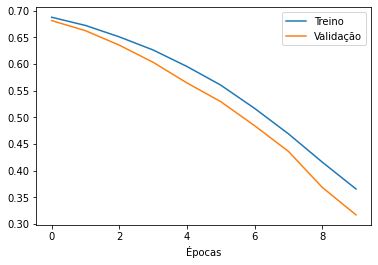

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_all_epoch)
plt.plot(val_loss_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

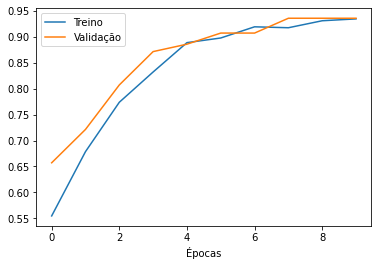

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accuracy_all_epoch)
plt.plot(val_accuracy_all_epoch)
plt.legend(['Treino', 'Validação'])
plt.xlabel('Épocas')

plt.show()

In [ ]:
from sklearn.metrics import classification_report

cnn.train(False)

all_pred = torch.tensor([]).to(device)
all_true = torch.tensor([]).to(device)

for data in test_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    all_pred = torch.cat((all_pred,y_pred))
    all_true = torch.cat((all_true,y_test))

all_true = all_true.to('cpu')
all_pred = all_pred.to('cpu')
print(classification_report(all_true,all_pred,zero_division=1))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93        70
         1.0       0.91      0.97      0.94        70

    accuracy                           0.94       140
   macro avg       0.94      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140



In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(size=(299, 299)),
        transforms.ToTensor(),
        transforms.Normalize([0.5875, 0.5591, 0.4995], [0.2855, 0.2831, 0.3047])
    ]
)

dir_val = torchvision.datasets.ImageFolder('drive/MyDrive/Pytorch/Teste',transform=transform)
val_data = torch.utils.data.DataLoader(dir_val,batch_size=32,shuffle=False,num_workers=0)

In [ ]:
from sklearn.metrics import classification_report

cnn.train(False)

for data in val_data:
    x_test,y_test = data
    x_test = x_test.to(device)
    y_test = y_test.to(device)
    y_pred = cnn(x_test)
    y_pred = y_pred.softmax(dim=1)
    print(y_pred)
    y_pred = torch.Tensor.argmax(y_pred, dim=1)
    print(y_test,y_pred)

tensor([[0.5733, 0.4267],
        [0.2327, 0.7673],
        [0.3181, 0.6819],
        [0.3648, 0.6352],
        [0.1096, 0.8904]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 1, 1, 1], device='cuda:0') tensor([0, 1, 1, 1, 1], device='cuda:0')
